In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
#DATASET LINK

# https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset/data

In [28]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import ImageEnhance, Image
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
data_dir = "C:/Users/SWEETY/OneDrive/Desktop/Deep Learning/Facial Emotion Detection/dataset"  # Update this

# Parameters
img_size = (224, 224)
batch_size = 64
seed = 42

# Get all image paths and labels
def get_image_paths_and_labels(data_dir):
    class_names = sorted(os.listdir(data_dir))
    image_paths = []
    labels = []

    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(('png', 'jpg', 'jpeg')):
                    image_paths.append(os.path.join(class_dir, fname))
                    labels.append(label_idx)
    return image_paths, labels, class_names

image_paths, labels, class_names = get_image_paths_and_labels(data_dir)

# Count full dataset class distribution
class_counts_full = Counter(labels)
print("Full dataset class counts:", {class_names[k]: v for k, v in class_counts_full.items()})

# Stratified split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=seed
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed
)

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

eval_datagen = ImageDataGenerator(rescale=1./255)

# Combined dataset creator

def create_dataset(image_paths, labels, datagen, target_size=(224, 224), batch_size=64, shuffle=True):
    # Map numeric labels to class names
    label_names = [class_names[label] for label in labels]
    
    df = pd.DataFrame({
        'filename': image_paths,
        'class': label_names  # string labels
    })

    base_dir = os.path.commonpath(image_paths)
    df['filename'] = df['filename'].apply(lambda x: os.path.relpath(x, base_dir))

    dataset = datagen.flow_from_dataframe(
        dataframe=df,
        directory=base_dir,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=shuffle,
        seed=seed
    )
    return dataset
# Create datasets
train_dataset = create_dataset(train_paths, train_labels, train_datagen, target_size=img_size, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset(val_paths, val_labels, eval_datagen, target_size=img_size, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(test_paths, test_labels, eval_datagen, target_size=img_size, batch_size=batch_size, shuffle=False)

# Print sizes
print(f"\nTraining samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

# Count images per class
def count_images_per_class(labels, class_names):
    class_counts = Counter(labels)
    return {class_names[i]: class_counts[i] for i in range(len(class_names))}

print("\nNumber of images per class:")
print("Training set:", count_images_per_class(train_labels, class_names))
print("Validation set:", count_images_per_class(val_labels, class_names))
print("Test set:", count_images_per_class(test_labels, class_names))


Full dataset class counts: {'Ahegao': 1205, 'Angry': 1312, 'Happy': 3739, 'Neutral': 4025, 'Sad': 3933, 'Surprise': 1234}
Found 12358 validated image filenames belonging to 6 classes.
Found 1545 validated image filenames belonging to 6 classes.
Found 1545 validated image filenames belonging to 6 classes.

Training samples: 12358
Validation samples: 1545
Test samples: 1545

Number of images per class:
Training set: {'Ahegao': 964, 'Angry': 1050, 'Happy': 2991, 'Neutral': 3220, 'Sad': 3146, 'Surprise': 987}
Validation set: {'Ahegao': 120, 'Angry': 131, 'Happy': 374, 'Neutral': 403, 'Sad': 394, 'Surprise': 123}
Test set: {'Ahegao': 121, 'Angry': 131, 'Happy': 374, 'Neutral': 402, 'Sad': 393, 'Surprise': 124}


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(224, 224, 3), num_emotions=6):
    inputs = tf.keras.Input(shape=input_shape)

    # Convolutional Blocks
    x = layers.Conv2D(32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(1024, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(2048, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_emotions, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = build_cnn_model(num_emotions=6)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 27,936,710 (106.57 MB)

 Trainable params: 27,928,582 (106.54 MB)

 Non-trainable params: 8,128 (31.75 KB)

In [15]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming you already have train_labels as a list of integers for classes
labels = np.array(train_labels)  # train_labels from your earlier code

# Get unique classes
classes = np.unique(labels)

# Compute class weights (balanced)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Optionally tweak some class weights manually, e.g.:
# Adjust class_weights_array according to your class indices
class_weights_array[0] *= 1.25  # e.g., class 0 weight increased by 25%
class_weights_array[4] *= 2.3   # e.g., class 4 weight increased by 130%
class_weights_array[3] *= 2.2   # e.g., class 3 weight increased by 120%

# Convert to dictionary for Keras model.fit
class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}

print(f"Computed Class Weights: {class_weights}")


Computed Class Weights: {0: 2.6707295988934994, 1: 1.9615873015873015, 2: 0.6886214198150006, 3: 1.407225672877847, 4: 1.505795719432083, 5: 2.0867950016886185}


In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001, decay=1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='min'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='C:/Users/SWEETY/OneDrive/Desktop/Deep Learning/Facial Emotion Detection/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,                  # should be a batched tf.data.Dataset or (X_train, y_train)
    validation_data=val_dataset,    # should be a batched tf.data.Dataset or (X_val, y_val)
    epochs=50,
    class_weight=class_weights,  # dict from previous step
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)

# After training
print(f"Training completed. Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2602 - loss: 2.4239
Epoch 1: val_loss improved from inf to 1.57894, saving model to C:/Users/SWEETY/OneDrive/Desktop/Deep Learning/Facial Emotion Detection/best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 1089s 6s/step - accuracy: 0.2603 - loss: 2.4236 - val_accuracy: 0.3217 - val_loss: 1.5789 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3044 - loss: 2.2399
Epoch 2: val_loss improved from 1.57894 to 1.46091, saving model to C:/Users/SWEETY/OneDrive/Desktop/Deep Learning/Facial Emotion Detection/best_model.keras
194/194 ━━━━━━━━━━━━━━━━━━━━ 1057s 5s/step - accuracy: 0.3044 - loss: 2.2397 - val_accuracy: 0.3172 - val_loss: 1.4609 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3371 - loss: 2.0670
Epoch 3: val_loss improved from 1.46091 to 1.44518, saving model to C:/Users/SWEETY/OneDrive/Desktop/Deep Learning/Facial Emotion Detection/best_mode

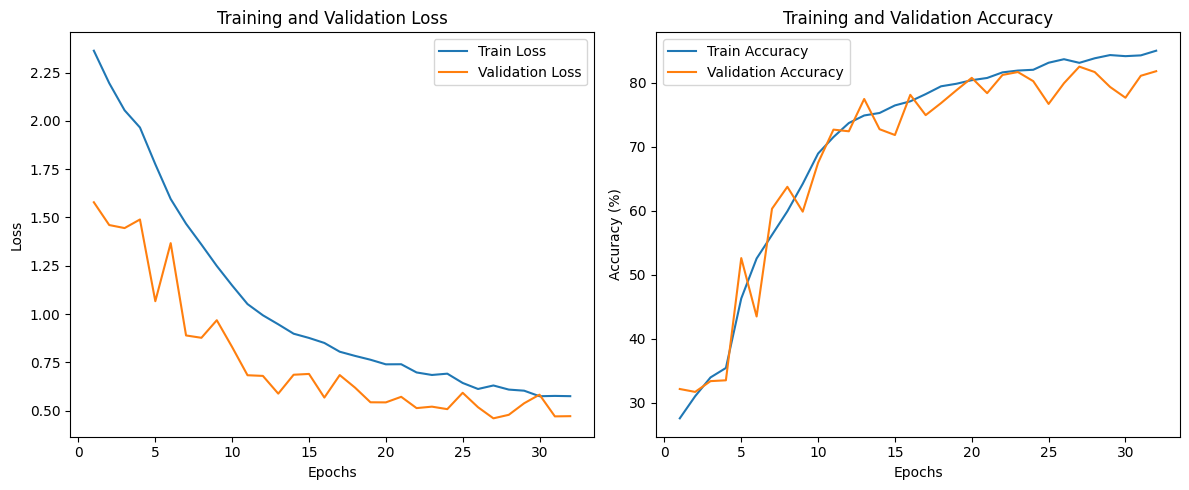

In [22]:
import matplotlib.pyplot as plt

# Number of epochs trained (automatically tracked by history object)
epochs_trained = len(history.history['loss'])

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_trained + 1), history.history['loss'], label='Train Loss')
plt.plot(range(1, epochs_trained + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_trained + 1), [acc * 100 for acc in history.history['accuracy']], label='Train Accuracy')
plt.plot(range(1, epochs_trained + 1), [val_acc * 100 for val_acc in history.history['val_accuracy']], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import numpy as np

# Load the best model (saved earlier using ModelCheckpoint)
best_model = load_model("best_model.keras")  # Ensure this path matches what was saved earlier

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc * 100:.2f}%")

# # Get predictions and true labels for further evaluation if needed
y_true = []
y_pred = []

for batch in test_dataset:
    images, labels = batch
    preds = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1) if labels.ndim > 1 else labels)
    y_pred.extend(np.argmax(preds, axis=1))

# Optional: Print accuracy again using sklearn for verification
sklearn_acc = accuracy_score(y_true, y_pred)
print(f"Sklearn Accuracy: {sklearn_acc * 100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8092 - loss: 0.4801
Test Loss: 0.4814 - Test Accuracy: 80.78%


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define class names if not already
# Example:
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
